In [1]:
import numpy as np
import pandas as pd
import random
import torch,torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchio as tio
import torchvision.transforms as transforms
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

In [2]:
# Get list of all image tensors for synapses
# These images are pre-padded and should be cut down to a size of 64^3 vx after augmentation transformations are performed
imgpath = './synaptic_feature_vectors/input_images_unpadded/' # '_old' <- using old images just so we can get this code working while correct images are generated
files = [f for f in listdir(imgpath) if isfile(join(imgpath,f))]

In [3]:
# Define image resolution so that voxel spacing in mm can be assigned to
# the images for each subject (translations for RandomAffine() are defined in mm)
mm_per_nm = 1e-6
xres_mmpvx = yres_mmpvx = 32*mm_per_nm
zres_mmpvx = 40*mm_per_nm

Populate training and test sets (80% and 20% of samples, respectively)

In [4]:
TRAIN_PCT = 0.80
train_set_size = int(np.ceil(TRAIN_PCT*len(files)))
train_files = random.sample(files,k=train_set_size)
test_files = list(set(files) - set(train_files))

In [5]:
# print(len(train_files)) # debugging
# print(len(test_files))
# print(len(train_files)/len(test_files))

Read (1) training and (2) test images and labels into subject lists

In [6]:
all_labels_raw = pd.read_csv('./synaptic_feature_vectors/pyr_inh_syn_feature_vectors_old_1.csv',index_col=0)
# Pre-processing step for current copy of label df: drop the 'cleft_vx_list' column. (It was mistakenly included.)
# This column won't be present in future versions of this df.
all_labels_raw.drop(columns=['cleft_vx_list'],inplace=True)
# Drop mito size since that won't be predictable (is much larger than these small volumes)
all_labels_raw.drop(columns=['mito_sizes_vx'],inplace=True)
# Drop rows for which the number of mitochondria is nan
all_labels_raw.drop(all_labels_raw[pd.isna(all_labels_raw['n_mitos'])].index,axis=0,inplace=True)

Label definitions:

0: excitatory cell

1: inhibitory cell

These classes apply to both the presynaptic cell and postsynaptic cell labels.

In [7]:
all_labels_raw.head(1) # debugging

,syn_id,cleft_x_vx,cleft_y_vx,cleft_z_vx,cleft_size_vx,presyn_soma_dist_um,postsyn_soma_dist_um,presyn_cell_id,presyn_cell_type,presyn_cell_subtype,postsyn_cell_id,postsyn_cell_type,postsyn_cell_subtype,n_mitos
0,1484,91369,57798,1582,798,221.313279,85.49189,648518346349539437,e,pyramidal,648518346349531254,e,pyramidal,0.0


In [8]:
# First pass: ONLY predict on the cell types. You can add the features back in later.
all_labels = all_labels_raw[['syn_id','presyn_cell_type','postsyn_cell_type']]
prect_int = [1 if q == 'e' else 0 for q in list(all_labels_raw['presyn_cell_type'])]
postct_int = [1 if q == 'e' else 0 for q in list(all_labels_raw['postsyn_cell_type'])]
all_labels = pd.DataFrame(data={'syn_id':all_labels_raw['syn_id'],'presyn_cell_type':prect_int,'postsyn_cell_type':postct_int})
# all_labels = all_labels_raw[['syn_id','presyn_cell_subtype','postsyn_cell_subtype']]
# print(np.unique(all_labels1['presyn_cell_subtype'])) # debugging
# print(np.unique(all_labels1['postsyn_cell_subtype'])) # debugging

In [9]:
# Compute the number of outputs
n_labels = len(all_labels.loc[all_labels.index[0]].values.tolist()) - 1 # subtract 1 to remove the syn_id key column
print(n_labels)

2


In [10]:
def generate_dataset(
        imgpath,
        file_set,
        scale_array=None,
        transform=None,
        device=torch.device("cpu"),
        dtype=torch.float32):
    
    # Read in image tensors to a subject list
    file_extension = '.npy'
    synapse_images = []

    for f in file_set[1:500]:
        pathcurr = imgpath + f
        synidcurr = f[:-len(file_extension)]
        # Define labels according to one-hot construction
        # Is this the best place to define labels in this way?
        labelscurr = torch.tensor(
            all_labels.loc[all_labels['syn_id'] == int(synidcurr)][['presyn_cell_type','postsyn_cell_type']].values[0, :],
            device=device, dtype=torch.float32) # torch.long raised an error
        tensorcurr = np.squeeze(np.load(pathcurr))

        # Apply (hand-designed, for now) corrections to the tensor to standardize values
        # onto the interval [0,1]
        # also, clamp everything to 1.
        tensorcurr = torch.tensor(tensorcurr / scale_array[:, None, None, None], device=device, dtype=dtype)
        tensorcurr = torch.clamp(tensorcurr, min=0., max=1.)
        
        # Put tensor into a torchio scalar image object
        imcurr = tio.ScalarImage(
            tensor=tensorcurr,
            spacing=(xres_mmpvx,yres_mmpvx,zres_mmpvx))

        synimg_subject_curr = tio.Subject(
            images=imcurr,
            synid=synidcurr,
            labels=labelscurr)

        # Append to subject list (subject lists only pull images when an operation is performed)
        synapse_images.append(synimg_subject_curr)
        
    # Build dataset
    dataset = tio.data.SubjectsDataset(
        subjects=synapse_images,
        load_getitem=False,
        transform=transform)
        
    return dataset

In [11]:
# Define scaling parameters for the channels in this dataset
# n_mitos_max = np.max(list(all_labels_raw['n_mitos']))
# scales = [255,1,1,1,n_mitos_max]
# Scale mitochondria channel so all mitochondria have label 1
scale_array = np.asarray([255,1,1,1,1])

In [12]:
train_dataset = generate_dataset(imgpath,train_files,scale_array=scale_array)#,transform=transform_std)
test_dataset = generate_dataset(imgpath,test_files,scale_array=scale_array)#,transform=transform_std)

Set parameters for augmentation transform

In [13]:
# Compute the widths of each synapse image in mm, so that the translation bounds for RandomAffine() can be determined
dxvx = dyvx = dzvx = 64
dxmm = dxvx * xres_mmpvx
dymm = dyvx * yres_mmpvx
dzmm = dzvx * zres_mmpvx

# Set parameter that *should* allow a crop to 32 px on a side to result in completely information-full images
# post-transform
transl_frac = 0.09
rot_min_deg = 0
rot_max_deg = 360

# Set other affine parameters
scale_min = 0.95
scale_max = 1.05

# Set finalized crop shape based on your calculations above
final_shape = 32

# To do: check that 32 px on a side is sufficient to capture a cleft and some
# of its pre- and postsynaptic partners

Construct transforms for augmentations

In [14]:
# RandomFlip()
# Allow flip about any axis
randflip = tio.RandomFlip(axes = (0,1,2),flip_probability = 1.0) # flip across any axis

# RandomAffine()
# Notes about parameters:
# scales: no scaling because absolute size is likely important
# degrees of rot.: could in priniciple be by any amount about any axis
# scale and rotate about image center
# shift in any dir by 16 px?
randaff = tio.RandomAffine(degrees = (rot_min_deg,rot_max_deg), \
                           center = 'image', \
                           translation = (transl_frac*dxmm,transl_frac*dymm,transl_frac*dzmm) \
                          )

# Intensity-based transforms:
# RandomNoise()
# Gaussian noise. mu chosen on U(arg1,arg2) or U(-arg,+arg), default 0.
# std chosen on U(arg1,arg2) or U(-arg,+arg), default (0,0.25)
randnoise = tio.RandomNoise(mean=(0,0.5),std=(0,0.25))

# RandomGamma()
# Alters contrast by exponentiating elements. Argument is gamma = e^beta
# beta is chosen on U(arg1,arg2) or U(-arg,+arg). default is (-0.3,0.3)
randgamma = tio.RandomGamma()

# Crop down to 32 px on a side
crop = tio.CropOrPad(target_shape=final_shape) # chunks are initially padded to 64 px

# Compose transforms
# aug_transforms = tio.Compose([randflip,tio.OneOf({randaff:1.0},p=0.5),crop]) # code showing how to make prob(aff)=0.5
aug_transforms = tio.Compose([randflip,randaff,randnoise,randgamma,crop])

STRATEGY #1:

Implement LeNet in 3D, 80% train/20% test split, predict only types of pre- and postsynaptic cells, keep track of loss per iteration for train set and loss per 100 iterations for test set (pull samples randomly from test set for that computation) using categorical cross entropy as loss, and keep track of accuracy in prediction per iteration for training set and per 100 iterations for test set)

Define net

In [15]:
class Net(nn.Module):
    
    def __init__(
            self,
            device: torch.device = torch.device("cpu"),
            dtype: torch.dtype = torch.float32):
        super(Net, self).__init__()        
        # 5 input image channels per sample (32 x 32 x 32 vx)
        # initial arg1 was 30 instead of 10
        self.conv1 = nn.Conv3d(5,10,5) # Starting smaller just to see what will run (2 features per channel ish)
        
        # Second convolutional step
        # initial arg0: 30. initial arg1: 80
        self.conv2 = nn.Conv3d(10,20,5)
        
        self.fc1 = nn.Linear(20*5*5*5,120) # 20 channels at 5x5*5 px post-max pool step (again trying to start smaller)
        self.fc2 = nn.Linear(120,84) # not sure why these intermediate steps are necessary
        self.fc3 = nn.Linear(84,n_labels) # get it down to a size 14 vector to match the features you've measured?
        
        self.to(device)
        self.type(dtype)
        
    # You define the forward() function and the backward() function is automatically defined using autograd
    def forward(self, x):
        # Max pooling over a (2,2,2) window
        x = F.max_pool3d(F.relu(self.conv1(x)), 2) # the maxpool is performed on the ReLU of the convolved input
        # print(np.shape(x)) # debugging
        
        # Max pooling over a (2,2,2) window after performing convolution #2 on ^that result
        x = F.max_pool3d(F.relu(self.conv2(x)), 2)
        # print(np.shape(x)) # debugging
        
        # We're now flattening the whole set of features across all channels and we want to downsample?
        # Or reshape?
        x = x.view(-1, self.num_flat_features(x))
        # print(np.shape(x)) # debugging
        
        # Turn maxpooled images into a fully-connected vector and apply relu to remove negative activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Don't perform ReLU on the final output because we want to see what the actual results are
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x)     :
        size = x.size()[1:] # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


#### START HERE: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

Load training data in mini-batches, augment each item in the structure appropriate for contrastive learning, and implement contrastive learning

In [16]:
# Define batch loading object for subject dataset using PyTorch DataLoader object
# Batch size is typically between 50 and 256?
BATCH_SIZE = 2 #50
train_batch_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE)
test_batch_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE)

In [17]:
# Initialize the net
net = Net()
# Initialize cross entropy loss criterion
# (this one is classification-label-based loss)
criterion = nn.BCELoss()
# Initialize contrastive loss criterion
# (this one is metric-learning-based loss)
# TO DO: define or initialize if it already exists
#contrast_criterion = []
# Set learning rate
LR = 0.001 # if this learning rate does not lead to settling with Adam, decrease to 10^-3
# Initialize optimizer
optimizer = optim.Adam(net.parameters(),lr=LR)
# Number of epochs (usually between 100 and 500?)
nepochs = 100

In [18]:
# Set iteration frequency at which checks will occur
N_ITERS_LOG_TRAIN = 50#2000
N_ITERS_TEST_FRAC = 10#20
N_ITERS_LOG_TEST = N_ITERS_LOG_TRAIN/N_ITERS_TEST_FRAC

In [19]:
# Testing
# batchdata = next(iter(train_batch_loader))
# bi = batchdata['images']['data']
# bi = batchdata.imag
# bic = torch.from_numpy(np.expand_dims(crop(np.squeeze(bi)),axis=0))
# bic = torch.rand((5,5,32,32,32))
# out = net(bic)

In [20]:
def batch_apply(batch,transform,fshape=None):
    # There has to be a built-in function for this, right?
    if fshape == None:
        fshape = np.shape(batch[-1])
    batchfinal = torch.tensor(
        np.zeros((np.shape(batch)[0],np.shape(batch)[1],fshape,fshape,fshape)),
        device=torch.device("cpu"),
        dtype=torch.float32)
    for bidx in range(len(batch)):
        batchfinal[bidx] = transform(batch[bidx])
        
    return batchfinal

In [21]:
def cosine_sim(t1,t2):
    # @t1, @t2: input tensors
    # returns cosine similarity by performing inner product of normalized tensors
    t1 = torch.squeeze(t1)
    t2 = torch.squeeze(t2)
    norm = torch.multiply(torch.norm(t1),torch.norm(t2))
    cos = torch.divide(torch.dot(t1,t2),norm)
    return cos

In [22]:
def contrastive_loss(pos,neg,temp=0.07):
    # @pos: similarity function of the positive input
    # @neg: similarity function of the negative input
    # @temp: temperature parameter for contrastive loss (values between 0.05 and 0.1 seem reasonable)
    # computes and returns contrastive log loss
    alllogits = torch.cat((pos,neg))/temp
    expinputs = torch.exp(alllogits)
    loss = -torch.log(expinputs[0]/torch.sum(expinputs))
    return loss

In [23]:
nepochs = 2

epoch = 0
0


/usr/people/amw7/pinky100_VENV_python3p6/VENV_1/lib/python3.6/site-packages/torchio/transforms/augmentation/intensity/random_gamma.py:140: RuntimeWarning: Negative values found in input tensor. See the documentation for more details on the implemented workaround: https://torchio.readthedocs.io/transforms/augmentation.html#randomgamma
  warnings.warn(message, RuntimeWarning)
/usr/people/amw7/pinky100_VENV_python3p6/VENV_1/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
checking test and train loss at iter 49


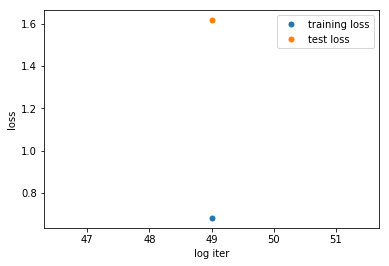

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
checking test and train loss at iter 99


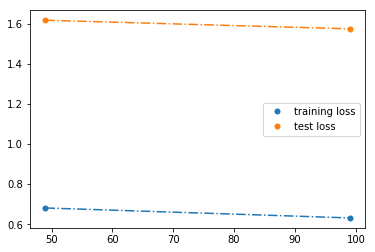

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
checking test and train loss at iter 149


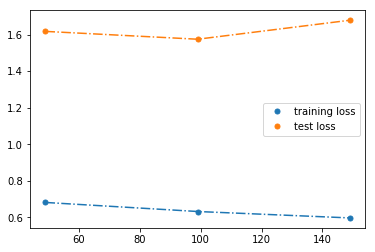

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
checking test and train loss at iter 199


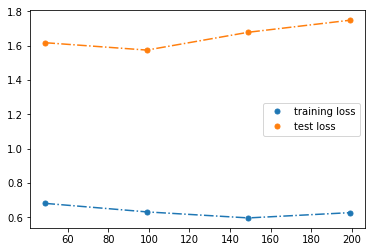

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
checking test and train loss at iter 249


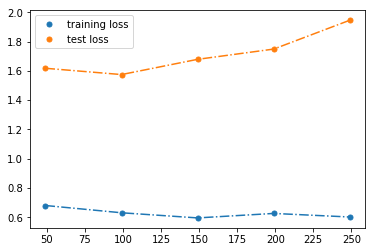

epoch = 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
checking test and train loss at iter 49


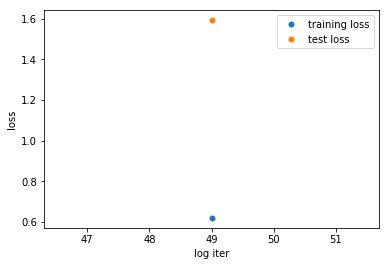

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
checking test and train loss at iter 99


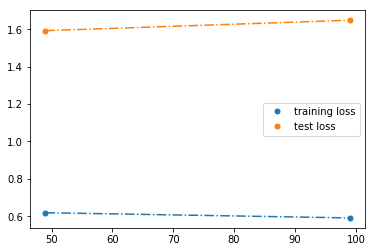

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
checking test and train loss at iter 149


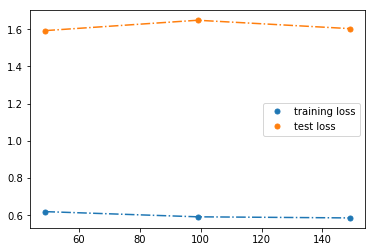

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
checking test and train loss at iter 199


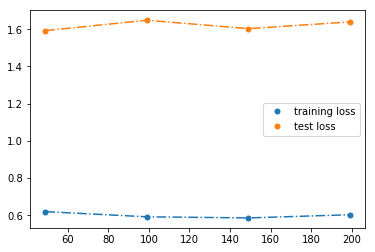

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
checking test and train loss at iter 249


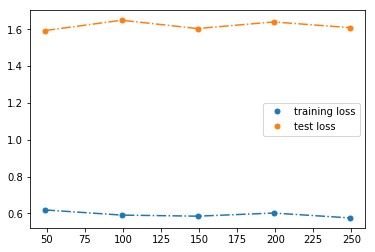

Finished training


In [24]:
for epoch in range(nepochs): # loop over the dataset multiple times
    print('epoch = {0}'.format(epoch))
    
    # Set up running loss plotting
    plt.figure()
    plt.xlabel('log iter')
    plt.ylabel('loss')
    iters_to_plot = []
    rl_train_to_plot = []
    rl_test_to_plot = []
    running_loss_train = 0
    running_loss_test = 0
    
    for i,data in enumerate(train_batch_loader,start=0):
        testiter = iter(test_batch_loader)
        batchinputsraw = data['images']['data']
        batchlabels = data['labels']
           
#         # Option 1: use a contrastive approach to augment the data and constrain
#         # the loss computation/weight updates
#         # Choose anchor and contrasting element at random from the minibatch
#         # (for transformation invariance)
#         ids = np.random.choice(np.shape(batchinputsraw)[0],2)
#         anchor = batchinputsraw[ids[0]]
#         negative = batchinputsraw[ids[1]]
#         # Get anchor and negative labels
#         alabel = batchlabels[ids[0]][None,:]
#         nlabel = batchlabels[ids[1]][None,:]
#         # Generate contrasting transforms
#         anchortrans = aug_transforms(anchor)[None,:]
#         postrans = aug_transforms(anchor)[None,:]
#         negtrans = aug_transforms(negative)[None,:]
#         # Run all through the net
#         optimizer.zero_grad()
#         atoutput = net(anchortrans)
#         ptoutput = net(postrans)
#         ntoutput = net(negtrans)
#         # Compute loss function components:
#         # (1) Compute classification label log loss (cross-entropy log loss)
#         lossa = criterion(torch.sigmoid(atoutput),alabel)
#         lossp = criterion(torch.sigmoid(ptoutput),alabel)
#         lossn = criterion(torch.sigmoid(ntoutput),nlabel)
#         # (2) Compute contrastive metric learning log loss 
#         losscontrast = contrastive_loss(cosine_sim(atoutput,ptoutput)[None],cosine_sim(atoutput,ntoutput)[None])
#         # Sum losses
#         loss = lossa + lossp + lossn + losscontrast
        
        # Option 2: Augment the whole minibatch and update that way
        # Augment minibatch
        batchinputs = batch_apply(batchinputsraw,aug_transforms,fshape=final_shape)
        #print(np.shape(batchinputs))
        # When augmentation is not used, crop images to 32 px on a side
        # batchinputs = batch_apply(batchinputsraw,crop,fshape=final_shape)
        # Zero parameter gradient buffers
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(batchinputs)
        loss = criterion(torch.sigmoid(outputs),batchlabels)

        # Use loss to perform gradient-based weight updates
        loss.backward() # see how much the loss changed with differences in weights
        optimizer.step() # update the weights in the network
        running_loss_train += loss.item()
        
        # Compute test set loss at regular intervals
        if i % N_ITERS_LOG_TEST == (N_ITERS_LOG_TEST-1):
            #print('computing test loss')
            tbc = testiter.next()
            testinputs = tbc['images']['data']
            testinputscropped = batch_apply(testinputs,crop,fshape=final_shape)
            testlabels = tbc['labels']
            testoutputs = net(testinputscropped)
            losstest = criterion(torch.sigmoid(testoutputs),testlabels)
            running_loss_test += losstest.item()
        
        # Plot average train and test losses
        if i % N_ITERS_LOG_TRAIN == (N_ITERS_LOG_TRAIN-1): 
            print('checking test and train loss at iter {0}'.format(i))
            rl_train_avg = running_loss_train/N_ITERS_LOG_TRAIN
            rl_test_avg = running_loss_test/N_ITERS_LOG_TEST
            iters_to_plot.append(i)
            rl_train_to_plot.append(rl_train_avg)
            rl_test_to_plot.append(rl_test_avg)
            #print('TRAIN LOSS LIST LENGTH: {0}'.format(len(rl_train_to_plot)))
            #print('TEST LOSS LIST LENGTH: {0}'.format(len(rl_test_to_plot)))
            
            # Plot average running training and test losses
            plt.plot(iters_to_plot,rl_train_to_plot,'-.',color='tab:blue')
            plt.plot(iters_to_plot,rl_train_to_plot,'.',color='tab:blue',markersize=10,label='training loss')
            plt.plot(iters_to_plot,rl_test_to_plot,'-.',color='tab:orange')
            plt.plot(iters_to_plot,rl_test_to_plot,'.',color='tab:orange',markersize=10,label='test loss')
            plt.legend(loc='best')
            plt.show()
            
            # Reset running losses for next set of 2000 iterations
            running_loss_train = 0.0
            running_loss_test = 0.0

print('Finished training')

***

In [25]:
# Refs:
# https://torchio.readthedocs.io/transforms/augmentation.html#spatial
# https://torchio.readthedocs.io/data/dataset.html
# https://torchio.readthedocs.io/quickstart.html


# Information about composing transformations:
# https://torchio.readthedocs.io/transforms/transforms.html#composability

# Information about patch-based pipelines:
# https://torchio.readthedocs.io/data/patch_based.html

# PyTorch DataLoader:
# https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader

# Example with a CNN (LeNet):
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

# Info about backprop
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#backprop

# Another helpful derivation of backpropagation and neural network training:

# Log loss:
# https://jbencook.com/cross-entropy-loss-in-pytorch/
# https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

# Optimizers:
# https://ruder.io/optimizing-gradient-descent/